In [2]:
import pandas as pd
import pyreadr
import torch
import numpy as np

device = torch.device("cuda:0")

print("GPU is available." if torch.cuda.is_available() is True else "GPU is unavailable")
print("Current device is: ")
print(device)

GPU is unavailable
Current device is: 
cuda:0


In [8]:
tmp = torch.randn(3, 3)
print(tmp.mean(axis=0))
print(tmp)
tmp[range(len(tmp)), range(len(tmp))] = tmp.diagonal() + 2
print(tmp)

tensor([ 0.1958,  0.5638, -0.3071])
tensor([[ 0.5551,  1.2632,  0.4338],
        [-0.6013, -0.8108, -0.0265],
        [ 0.6336,  1.2390, -1.3285]])
tensor([[ 2.5551,  1.2632,  0.4338],
        [-0.6013,  1.1892, -0.0265],
        [ 0.6336,  1.2390,  0.6715]])


In [3]:
import netCDF4
ncin = netCDF4.Dataset('./data/wind_residual_all_locations.nc', 'r', format='NETCDF4')

In [4]:
wind_residual_all_locations = ncin.variables['wind_residual_all_locations'][:]
lat_all_locations = ncin.variables['lat_all_locations'][:]
lon_all_locations = ncin.variables['lon_all_locations'][:]
ncin.close()

In [11]:
# Wind energy data is sampled per hour, and assumed that there is no leap year.
int(wind_residual_all_locations.shape[1] / (365 * 24))

4

In [5]:
import netCDF4
ncin = netCDF4.Dataset('./data/wind_residual.nc', 'r', format='NETCDF4')
wind_residual = ncin.variables['wind_residual'][:]
lat = ncin.variables['lat'][:]
lon = ncin.variables['lon'][:]
ncin.close()

In [6]:
lon = lon.reshape(-1, 1)
lat = lat.reshape(-1, 1)
grid = np.concatenate((lon, lat), axis=1)

In [65]:
from sklearn.neighbors import NearestNeighbors
import time

print("Starting the timer...")
tic = time.time()
nbrs = NearestNeighbors(n_neighbors=9, algorithm='auto').fit(grid)
toc = time.time()
distances, indices = nbrs.kneighbors(grid)
print(f"Finding k nearest neighbours using {toc - tic:0.3f} seconds")


Starting the timer...
Finding k nearest neighbours using 0.002 seconds


In [66]:
indices = indices[:,1:]
print(indices)
print(indices.shape)

[[3113 3117    1 ... 3124    2 3128]
 [3120 3124 3113 ...    0    5    2]
 [3134 3130 3128 ... 3120 3143 3139]
 ...
 [3167 3171   15 ... 3164    8 3165]
 [3170 3167   15 ... 3164 3172 3165]
 [   9 3171 3170 ... 3167 3166 3168]]
(3173, 8)


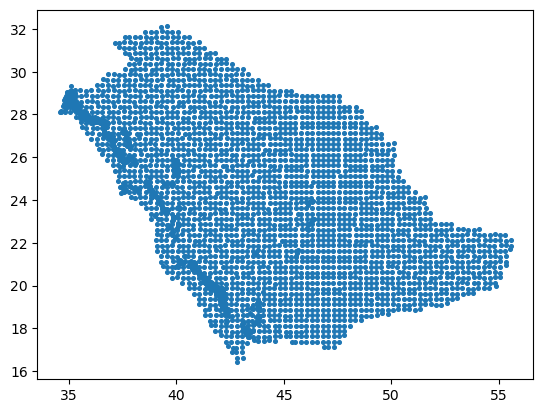

In [10]:
from matplotlib import pyplot as plt
import matplotlib

x, y = grid.T
plt.scatter(x, y, s=7)
plt.savefig("./figs/grid.png")
plt.show()

In [17]:
from sklearn.neighbors import NearestNeighbors
import time

X = np.array(np.random.rand(3173, 2)) # 3173 is our selected knots
print("Starting the timer...")
tic = time.time()
nbrs = NearestNeighbors(n_neighbors=4, algorithm='auto').fit(X)
toc = time.time()
distances, indices = nbrs.kneighbors(X)
print(f"Finding k nearest neighbours using {toc - tic:0.3f} seconds")

Starting the timer...
Finding k nearest neighbours using 0.002 seconds


In [10]:
distances

array([[0.        , 0.01366361, 0.01379891, 0.01457026],
       [0.        , 0.01222995, 0.01289559, 0.01746228],
       [0.        , 0.00832091, 0.01155293, 0.01418399],
       ...,
       [0.        , 0.00772057, 0.00803325, 0.01319603],
       [0.        , 0.00972342, 0.01011838, 0.0138536 ],
       [0.        , 0.01670319, 0.01728715, 0.01792006]])

# Pseudo-code
Previously 
```
self.nColsU = self.numLocs * self.m + 1
```
Now
```
self.nColsU = self.numLocs * self.numLocs * self.m + 1
```

The filter $V_{tij}$ is defined as

$$
    V_{tij} = 
\begin{align}
    \bigg\{ \begin{array}{c}
    v_{tij}, \text{if $j$ belongs to the set of nearest neighbours of $i$} \\
    0, \text{otherwise} 
    \end{array}
\end{align}

$$
